## City Bikes Trips 2015 - 2017 Jersey City

In [1]:
import warnings

import numpy as np

warnings.filterwarnings("ignore")
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import folium
from pyproj import Geod


In [2]:
sns.set_style("whitegrid")

### 1. Loading dataset

In [3]:
df = pd.read_csv("data/NYC-BikeShare-2015-2017-combined.csv")
df.head()

,Unnamed: 0,Trip Duration,Start Time,Stop Time,Start Station ID,Start Station Name,Start Station Latitude,Start Station Longitude,End Station ID,End Station Name,End Station Latitude,End Station Longitude,Bike ID,User Type,Birth Year,Gender,Trip_Duration_in_min
0,0,376,2015-10-01 00:16:26,2015-10-01 00:22:42,3212,Christ Hospital,40.734786,-74.050444,3207,Oakland Ave,40.737604,-74.052478,24470,Subscriber,1960.0,1,6
1,1,739,2015-10-01 00:27:12,2015-10-01 00:39:32,3207,Oakland Ave,40.737604,-74.052478,3212,Christ Hospital,40.734786,-74.050444,24481,Subscriber,1960.0,1,12
2,2,2714,2015-10-01 00:32:46,2015-10-01 01:18:01,3193,Lincoln Park,40.724605,-74.078406,3193,Lincoln Park,40.724605,-74.078406,24628,Subscriber,1983.0,1,45
3,3,275,2015-10-01 00:34:31,2015-10-01 00:39:06,3199,Newport Pkwy,40.728745,-74.032108,3187,Warren St,40.721124,-74.038051,24613,Subscriber,1975.0,1,5
4,4,561,2015-10-01 00:40:12,2015-10-01 00:49:33,3183,Exchange Place,40.716247,-74.033459,3192,Liberty Light Rail,40.711242,-74.055701,24668,Customer,1984.0,0,9


### 2. Data information

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 735502 entries, 0 to 735501
Data columns (total 17 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   Unnamed: 0               735502 non-null  int64  
 1   Trip Duration            735502 non-null  int64  
 2   Start Time               735502 non-null  object 
 3   Stop Time                735502 non-null  object 
 4   Start Station ID         735502 non-null  int64  
 5   Start Station Name       735502 non-null  object 
 6   Start Station Latitude   735502 non-null  float64
 7   Start Station Longitude  735502 non-null  float64
 8   End Station ID           735502 non-null  int64  
 9   End Station Name         735502 non-null  object 
 10  End Station Latitude     735502 non-null  float64
 11  End Station Longitude    735502 non-null  float64
 12  Bike ID                  735502 non-null  int64  
 13  User Type                735502 non-null  object 
 14  Birt

### 3. Data preprocessing
We create following rules for the data:
1. Trip needs to last at least 1.5 minutes
2. Length of a trip needs to be at least 150 meters

In [5]:
original_shape = df.shape

#### Dropping rows where duration is less than 90 seconds

In [6]:
df = df.drop(df[df['Trip Duration'] < 90].index)
new_shape = df.shape

In [7]:
print(f"Number of rows dropped: {original_shape[0] - new_shape[0]}")

Number of rows dropped: 6107


### 4. Number of trips by date, day of week and hour

#### Converting start time to Datetime data type and creating new column: Start Date

In [8]:
df['Start Date'] = pd.to_datetime(df['Start Time']).dt.date
df['Start Date'] = pd.to_datetime(df['Start Date'])

In [9]:
ntd = df.groupby("Start Date")["Start Date"].agg(["count"]).reset_index()
ntd.columns = ["Date", "Trips"]
ntd.head()

,Date,Trips
0,2015-09-21,265
1,2015-09-22,565
2,2015-09-23,677
3,2015-09-24,661
4,2015-09-25,669


In [10]:
ntd.tail()

,Date,Trips
545,2017-03-27,1688
546,2017-03-28,1472
547,2017-03-29,2456
548,2017-03-30,2464
549,2017-03-31,636


#### Average trips per day

In [11]:
atpd = round(ntd["Trips"].mean())
print(f"Average trips per day: {atpd} trips")

Average trips per day: 1326 trips


#### 4.1. Number of trips per date

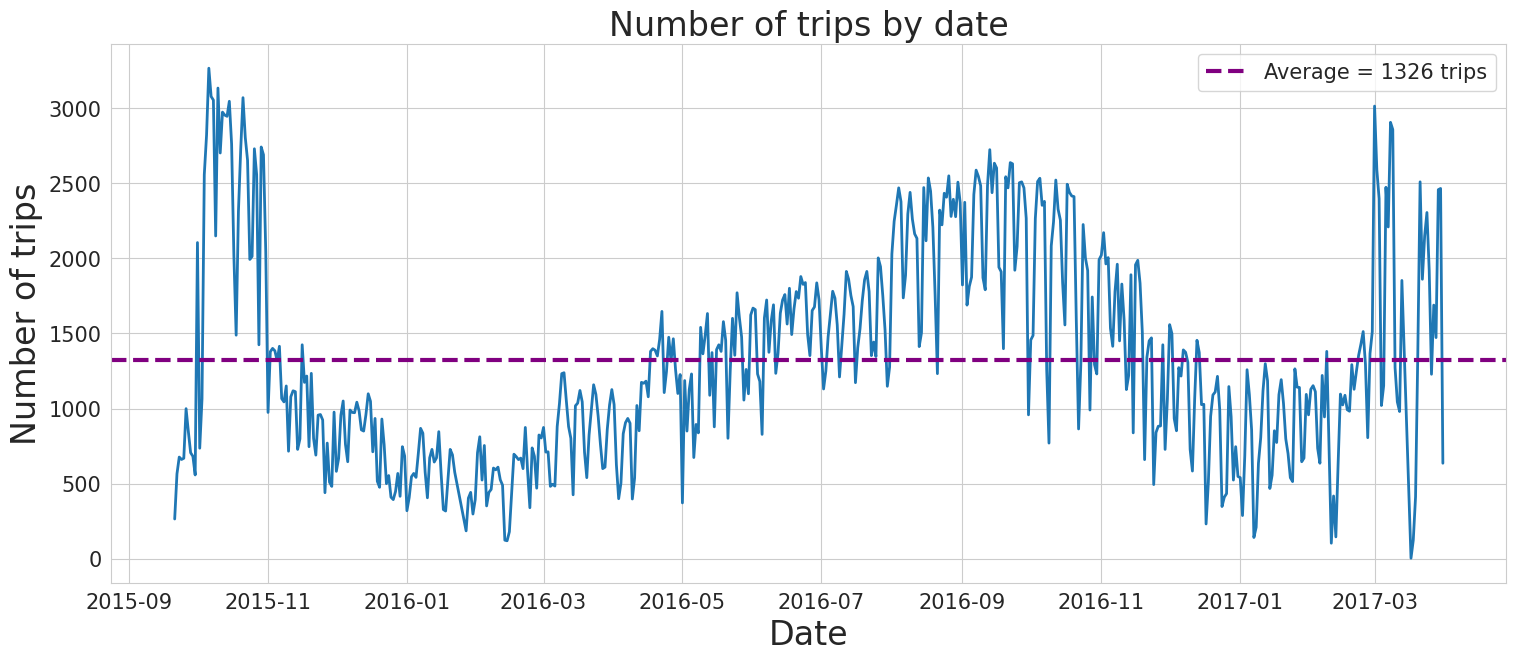

In [12]:
plt.figure(figsize=(18, 7))
plot = sns.lineplot(x="Date", y="Trips", data=ntd, linewidth=2)
plot.axhline(atpd, linestyle="--", color="purple", label=f"Average = {atpd} trips", linewidth=3)
plt.title("Number of trips by date", size=24)
plt.xlabel("Date", size=24)
plt.ylabel("Number of trips", size=24)
plt.legend(prop={'size': 15})
plt.xticks(size=15)
plt.yticks(size=15)
plt.show()

#### 4.2. Number of trips by day of week

#### Extracting day of week from Start Date column

In [13]:
df["Day Of Week"] = df["Start Date"].dt.day_name()

In [14]:
cats = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
tdw = df.groupby("Day Of Week")["Day Of Week"].agg(["count"]).reindex(cats).reset_index()
tdw.columns = ["Day Of Week", "Trips"]
tdw

,Day Of Week,Trips
0,Monday,108461
1,Tuesday,112483
2,Wednesday,120549
3,Thursday,118843
4,Friday,107979
5,Saturday,81987
6,Sunday,79093


#### Average trips per day of week

In [15]:
atdw = round(tdw["Trips"].mean())
print(f"Average trips per day of week: {atdw}")

Average trips per day of week: 104199


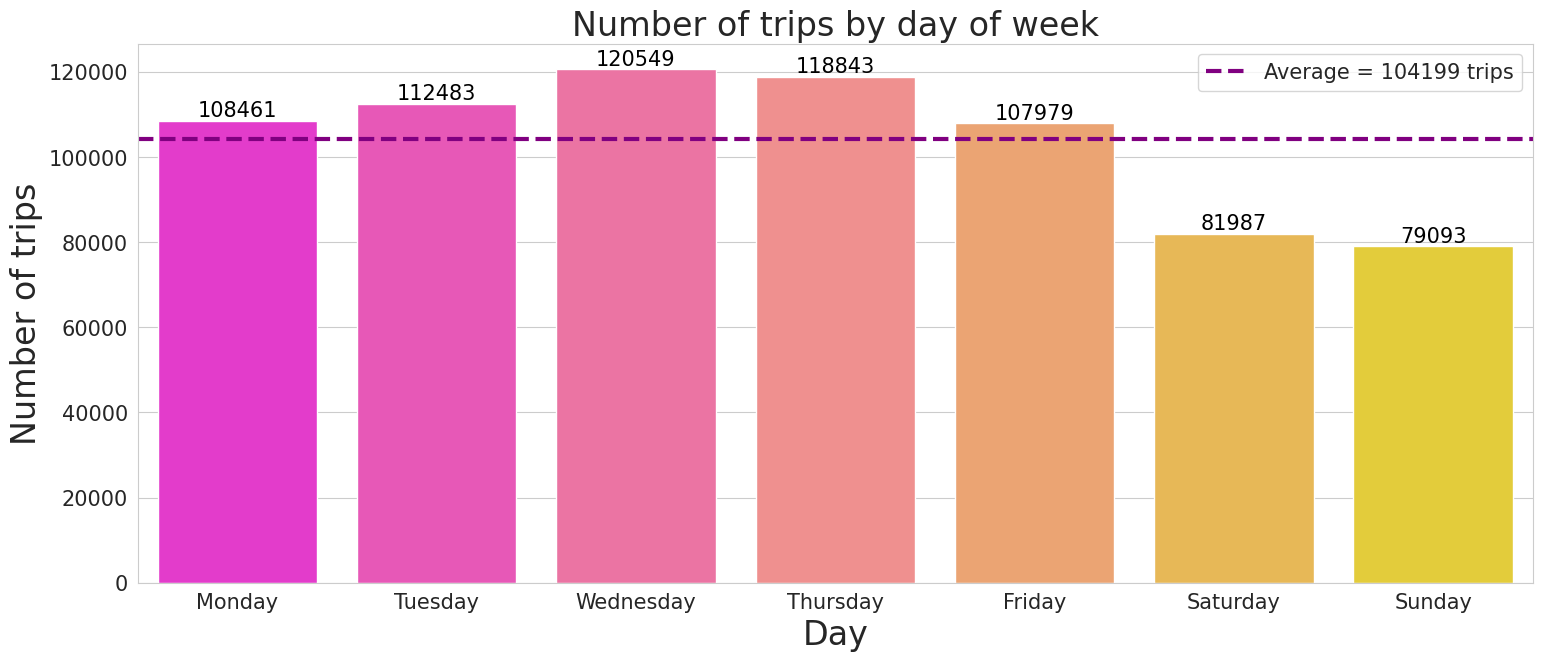

In [16]:
plt.figure(figsize=(18, 7))
plot = sns.barplot(x="Day Of Week", y="Trips", data=tdw, palette="spring")
for p in plot.patches:
    plot.annotate('{:.0f}'.format(p.get_height()),
                  (p.get_x() + 0.4, p.get_height()),
                  ha='center', va='bottom', color='black', size=15)
plot.axhline(atdw, linestyle="--", color="purple", label=f"Average = {atdw} trips", linewidth=3)
plt.title("Number of trips by day of week", size=24)
plt.xlabel("Day", size=24)
plt.ylabel("Number of trips", size=24)
plt.legend(prop={'size': 15})
plt.xticks(size=15)
plt.yticks(size=15)
plt.show()

#### 4.3. Distribution of trips over hours of the day

In [17]:
df["Hour"] = pd.to_datetime(df["Start Time"]).dt.hour

In [18]:
thd = df["Hour"].value_counts().to_frame().reset_index()
thd.columns = ["Hour", "Trips"]
thd

,Hour,Trips
0,8,86944
1,18,72183
2,17,65616
3,19,52747
4,7,49377
5,9,44234
6,16,39378
7,20,37512
8,15,32541
9,13,32008


#### Average trips per hour

In [19]:
athd = round(thd["Trips"].mean())
print(f"Average trips per hour: {athd}")

Average trips per hour: 30391


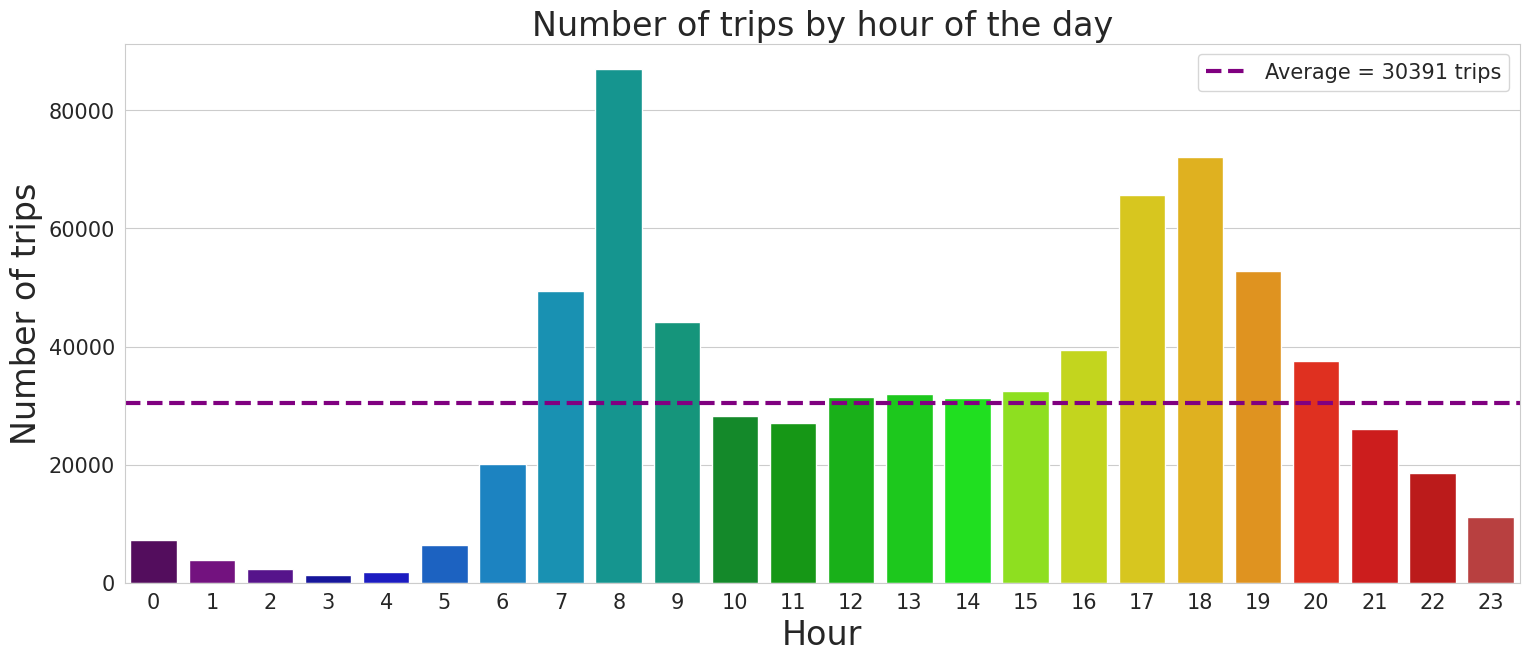

In [20]:
plt.figure(figsize=(18, 7))
plot = sns.barplot(x="Hour", y="Trips", data=thd, palette="nipy_spectral")
plot.axhline(athd, linestyle="--", color="purple", label=f"Average = {athd} trips", linewidth=3)
plt.title("Number of trips by hour of the day", size=24)
plt.xlabel("Hour", size=24)
plt.ylabel("Number of trips", size=24)
plt.legend(prop={'size': 15})
plt.xticks(size=15)
plt.yticks(size=15)
plt.show()

#### 4.4. Number of trips by start area

#### Adding new columns with information about the neighbourhood that given location is in and coordinates describing the center of this neighbourhood

In [21]:
from geopy.geocoders import Nominatim
geolocator = Nominatim(user_agent="geoapiExercises")

In [22]:
from tqdm import tqdm
road_map = {}
area_coords = {}
for row in tqdm(df.itertuples()):
    index = row.Index
    start_lat, end_lat = df.at[index, "Start Station Latitude"], df.at[index, "End Station Latitude"]
    start_lon, end_lon = df.at[index, "Start Station Longitude"], df.at[index, "End Station Longitude"]
    if start_lat not in road_map:
        start_loc = geolocator.reverse(f"{start_lat},{start_lon}")
        if start_loc and 'road' in start_loc.raw['address']:
            start_loc = start_loc.raw
            start_neigh = start_loc['address']['road']
            road_map[start_lat] = start_neigh
            try:
                area_center = geolocator.geocode(f"Jersey City {start_neigh}")
            except:
                area_center = None
            if area_center:
                area_coords[start_neigh] = {'lat': area_center.latitude, 'lon': area_center.longitude}
    if end_lat not in road_map:
        end_loc = geolocator.reverse(f"{end_lat},{end_lon}")
        if end_loc and 'road' in end_loc.raw['address']:
            end_loc = end_loc.raw
            end_neigh = end_loc['address']['road']
            road_map[end_lat] = end_neigh
            try:
                area_center = geolocator.geocode(f"Jersey City {end_neigh}")
            except:
                area_center = None
            if area_center:
                area_coords[end_neigh] = {'lat': area_center.latitude, 'lon': area_center.longitude}

729395it [03:07, 3893.42it/s] 


In [23]:
for row in tqdm(df.itertuples()):
    index = row.Index
    start_lat, end_lat = df.at[index, "Start Station Latitude"], df.at[index, "End Station Latitude"]
    if start_lat in road_map:
        start_neigh = road_map[start_lat]
        df.at[index, "Start Area Name"] = start_neigh
        if start_neigh in area_coords:
            df.at[index, "Start Centroid Latitude"] = area_coords[start_neigh]['lat']
            df.at[index, "Start Centroid Longitude"] = area_coords[start_neigh]['lon']
        
    if end_lat in road_map:
        end_neigh = road_map[end_lat]
        df.at[index, "End Area Name"] = end_neigh
        if end_neigh in area_coords:
            df.at[index, "End Centroid Latitude"] = area_coords[end_neigh]['lat']
            df.at[index, "End Centroid Longitude"] = area_coords[end_neigh]['lon']

729395it [01:23, 8705.48it/s]


In [24]:
ntbsa = df["Start Area Name"].value_counts().to_frame().reset_index()
ntbsa.columns = ["Start Area Name", "Trips"]
ntbsa

,Start Area Name,Trips
0,Christopher Columbus Drive,93097
1,Exchange Place,55571
2,Sip Avenue,49472
3,McWilliams Place,47518
4,Jersey Avenue,46245
5,Town Square Place,39865
6,Newark Avenue,35848
7,Brunswick Street,33381
8,Greene Street,28178
9,Newport Parkway,25574


#### 4.5. Number of trips by destination area

In [25]:
ntbea = df["End Area Name"].value_counts().to_frame().reset_index()
ntbea.columns = ["End Area Name", "Trips"]
ntbea

,End Area Name,Trips
0,Christopher Columbus Drive,120256
1,Exchange Place,64330
2,McWilliams Place,46724
3,Sip Avenue,46470
4,Town Square Place,39204
...,...,...
97,Perry Street,2
98,West 4th Street,2
99,Centre Street,2
100,East 3rd Street,2


### 5. Number of trips by Age, Gender

#### 5.1. Number of trips by age

In [26]:
df['Age'] = pd.to_datetime(df['Start Time']).dt.year - df['Birth Year'].astype('int')

In [27]:
tba = df["Age"].value_counts().to_frame().reset_index()
tba.columns = ["Age", "Trips"]
tba

,Age,Trips
0,32,75559
1,31,48987
2,33,37560
3,35,35677
4,30,35133
...,...,...
61,115,17
62,73,12
63,79,8
64,82,2


In [28]:
athba= round(tba["Trips"].mean())
print(f"Average trips per age: {athd}")

Average trips per age: 30391


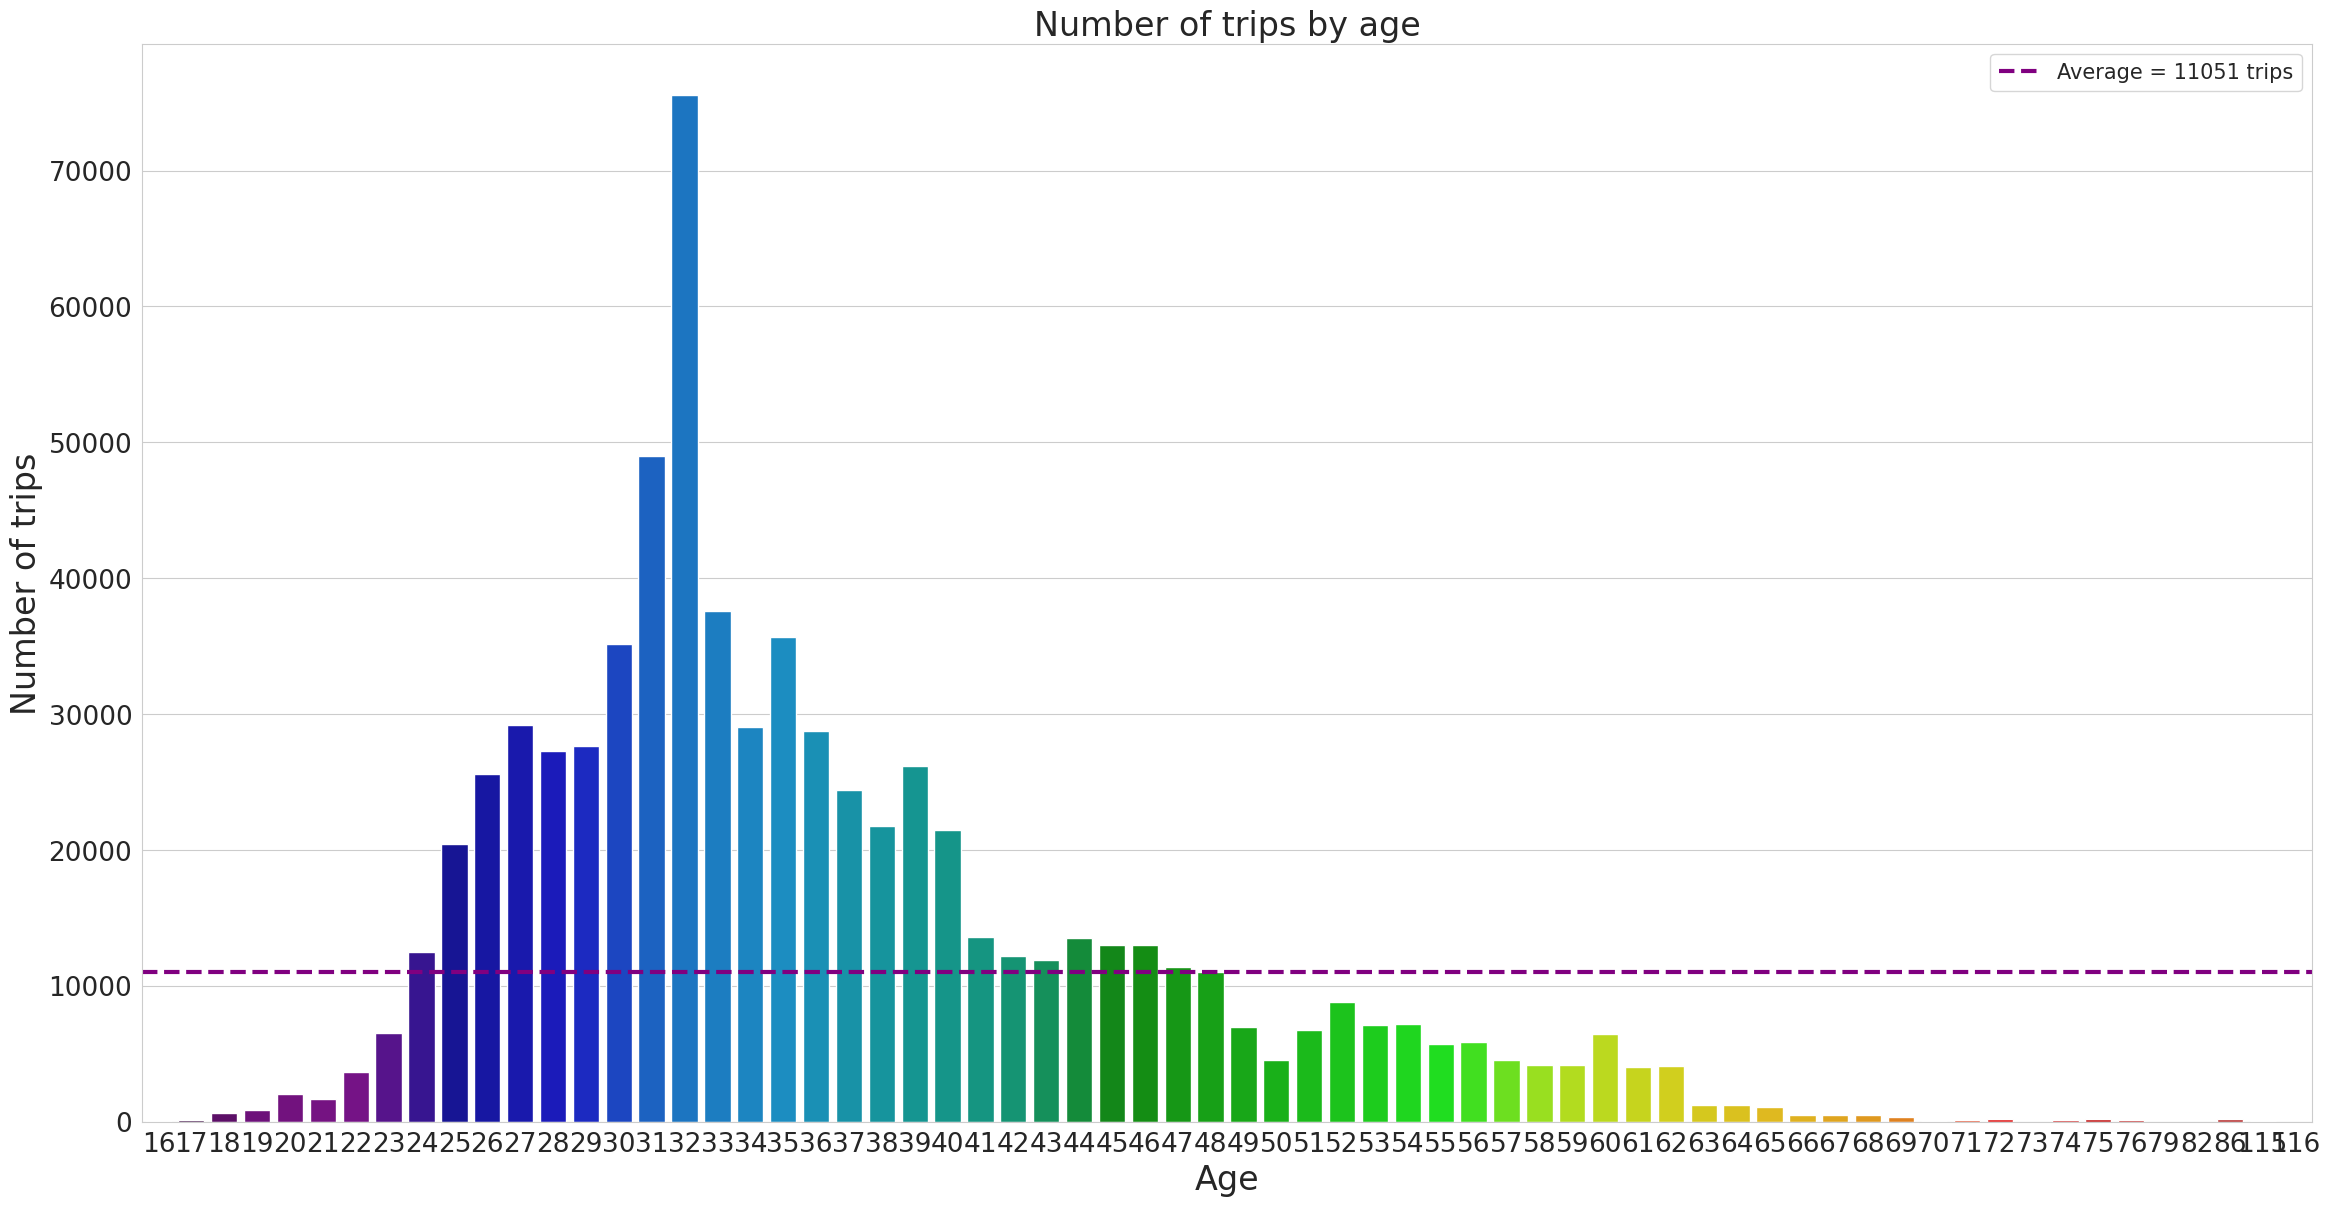

In [29]:
plt.figure(figsize=(28, 14))
plot = sns.barplot(x="Age", y="Trips", data=tba, palette="nipy_spectral")
plot.axhline(athba, linestyle="--", color="purple", label=f"Average = {athba} trips", linewidth=3)
plt.title("Number of trips by age", size=24)
plt.xlabel("Age", size=24)
plt.ylabel("Number of trips", size=24)
plt.legend(prop={'size': 15})
plt.xticks(size=19)
plt.yticks(size=19)
plt.show()

#### 5.2 Number of trips by gender

In [30]:
df["Gender"] = np.where(df['Gender']==0, 'Female', 'Male')

In [31]:
tbg = df["Gender"].value_counts().to_frame().reset_index()
tbg.columns = ["Gender", "Trips"]
tbg

,Gender,Trips
0,Male,670120
1,Female,59275


In [32]:
athbg= round(tbg["Trips"].mean())
print(f"Average trips per gender: {athbg}")

Average trips per gender: 364698


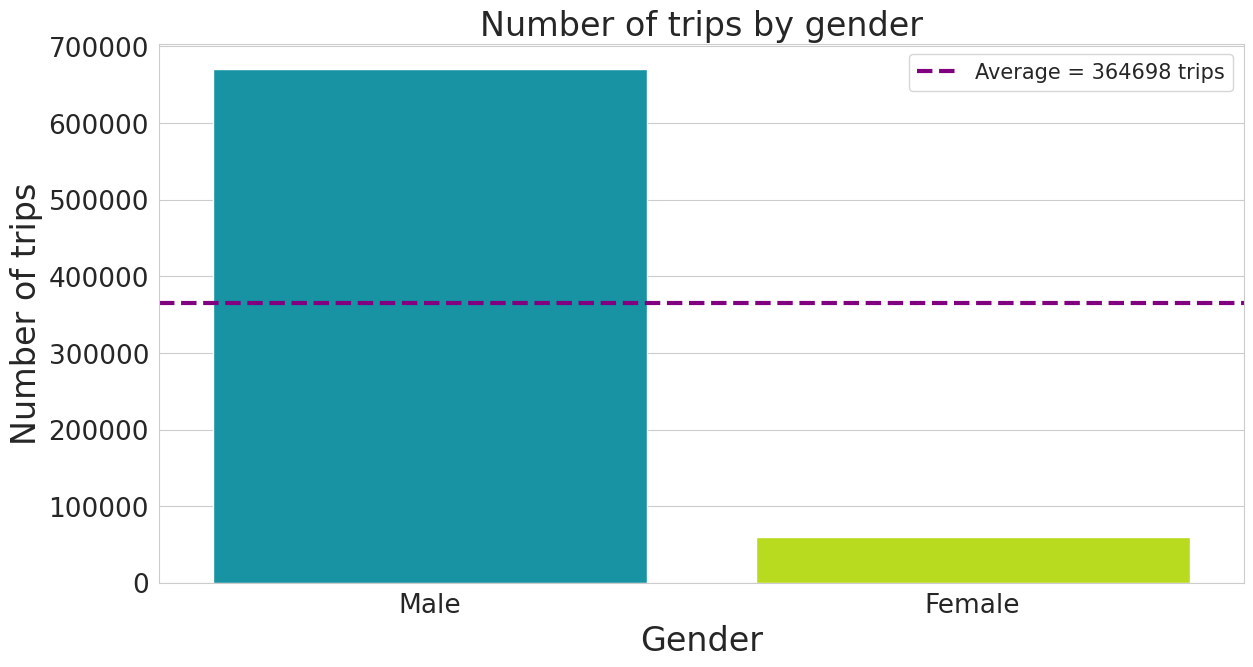

In [33]:
plt.figure(figsize=(14, 7))
plot = sns.barplot(x="Gender", y="Trips", data=tbg, palette="nipy_spectral")
plot.axhline(athbg, linestyle="--", color="purple", label=f"Average = {athbg} trips", linewidth=3)
plt.title("Number of trips by gender", size=24)
plt.xlabel("Gender", size=24)
plt.ylabel("Number of trips", size=24)
plt.legend(prop={'size': 15})
plt.xticks(size=19)
plt.yticks(size=19)
plt.show()

### 6. Average trip duration

In [34]:
avd = round(df["Trip_Duration_in_min"].mean(), 2)
print(f"Average duration of trip: {avd} minutes")

Average duration of trip: 15.69 minutes


#### 6.1. Average trip duration by date

In [35]:
atdbd = df.groupby(["Start Date"]).agg({"Trip_Duration_in_min": "mean"}).reset_index()
atdbd["Trip_Duration_in_min"] = round(atdbd["Trip_Duration_in_min"],2)
atdbd.columns = ["Date", "Trip Duration"]
atdbd.head()

,Date,Trip Duration
0,2015-09-21,24.63
1,2015-09-22,20.28
2,2015-09-23,18.19
3,2015-09-24,23.05
4,2015-09-25,13.76


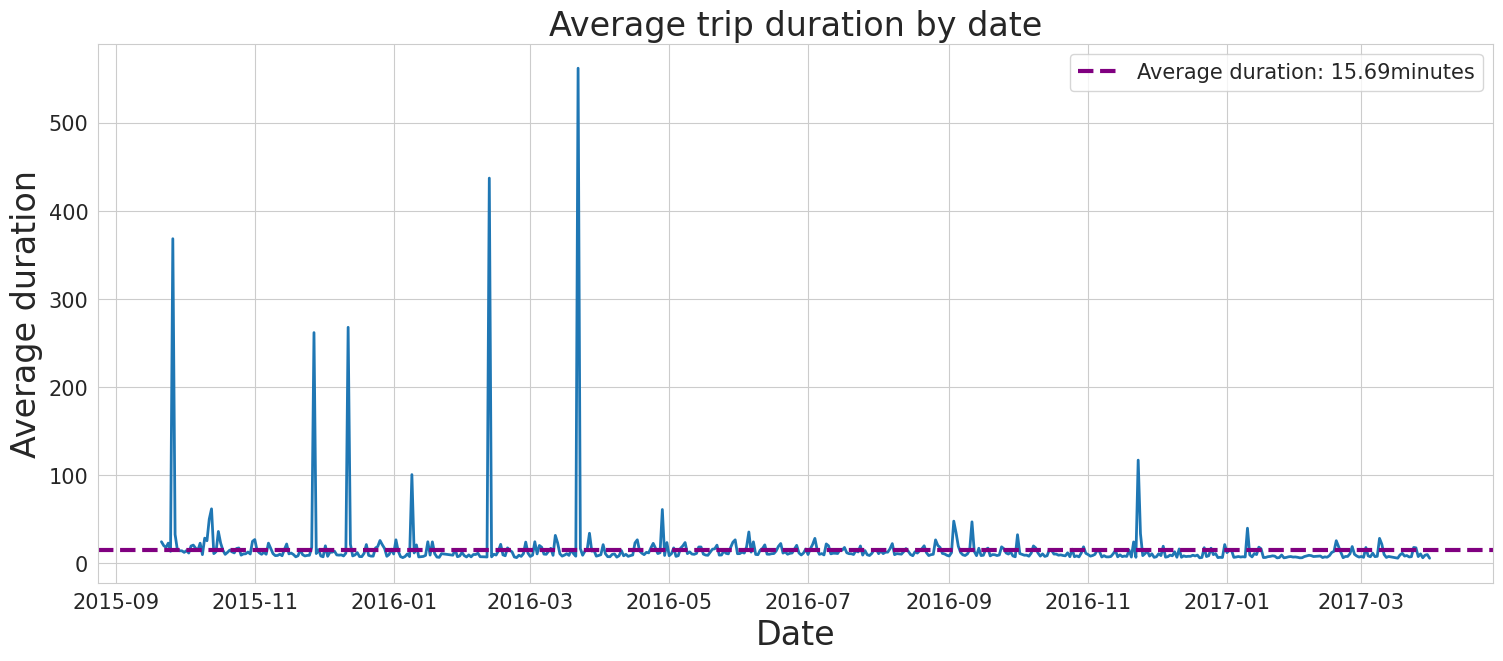

In [36]:
plt.figure(figsize=(18, 7))
plot = sns.lineplot(x="Date", y="Trip Duration", data=atdbd, linewidth=2)
plot.axhline(avd, linestyle="--", color="purple", label=f"Average duration: {avd}minutes", linewidth=3)
plt.title("Average trip duration by date", size=24)
plt.xlabel("Date", size=24)
plt.ylabel("Average duration", size=24)
plt.legend(prop={'size': 15})
plt.xticks(size=15)
plt.yticks(size=15)
plt.show()

#### 6.2. Average trip duration by day of week

In [37]:
adbd = df.groupby(["Day Of Week"]).agg({"Trip_Duration_in_min": "mean"})
adbd.columns = ["Average Trip Duration"]
adbd["Average Trip Duration"] = round(adbd["Average Trip Duration"],2)
adbd = adbd.reset_index()
adbd

,Day Of Week,Average Trip Duration
0,Friday,15.99
1,Monday,12.76
2,Saturday,25.63
3,Sunday,18.91
4,Thursday,11.79
5,Tuesday,17.14
6,Wednesday,11.69


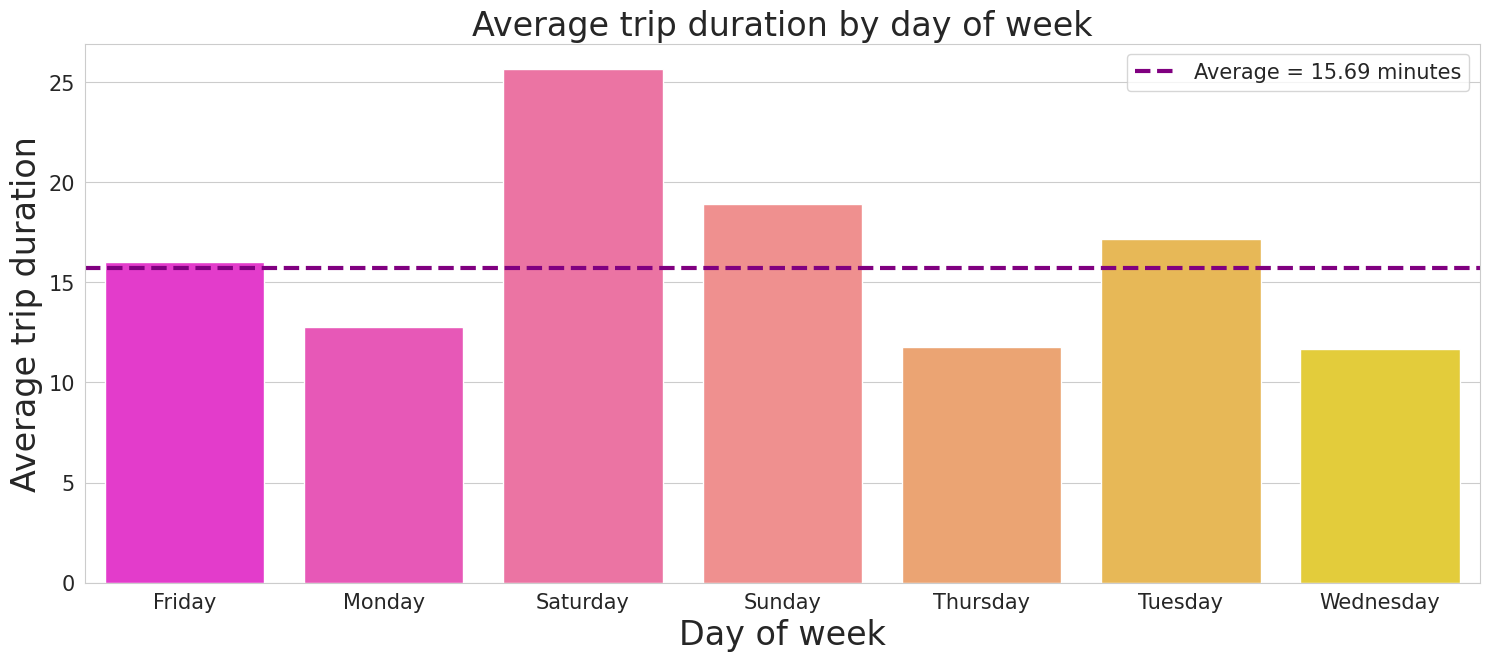

In [38]:
plt.figure(figsize=(18, 7))
plot = sns.barplot(x="Day Of Week", y="Average Trip Duration", data=adbd, palette="spring")
plot.axhline(avd, linestyle="--", color="purple", label=f"Average = {avd} minutes", linewidth=3)
plt.title("Average trip duration by day of week", size=24)
plt.xlabel("Day of week", size=24)
plt.ylabel("Average trip duration", size=24)
plt.legend(prop={'size': 15})
plt.xticks(size=15)
plt.yticks(size=15)
plt.show()

#### 6.3. Average trip duration by hour of the day

In [39]:
adbh = df.groupby(["Hour"]).agg({"Trip_Duration_in_min": "mean"})
adbh.columns = ["Average Trip Duration"]
adbh["Average Trip Duration"] = round(adbh["Average Trip Duration"],2)
adbh = adbh.reset_index()
adbh

,Hour,Average Trip Duration
0,0,14.06
1,1,18.81
2,2,19.24
3,3,14.34
4,4,199.53
5,5,15.89
6,6,7.54
7,7,20.46
8,8,10.30
9,9,12.68


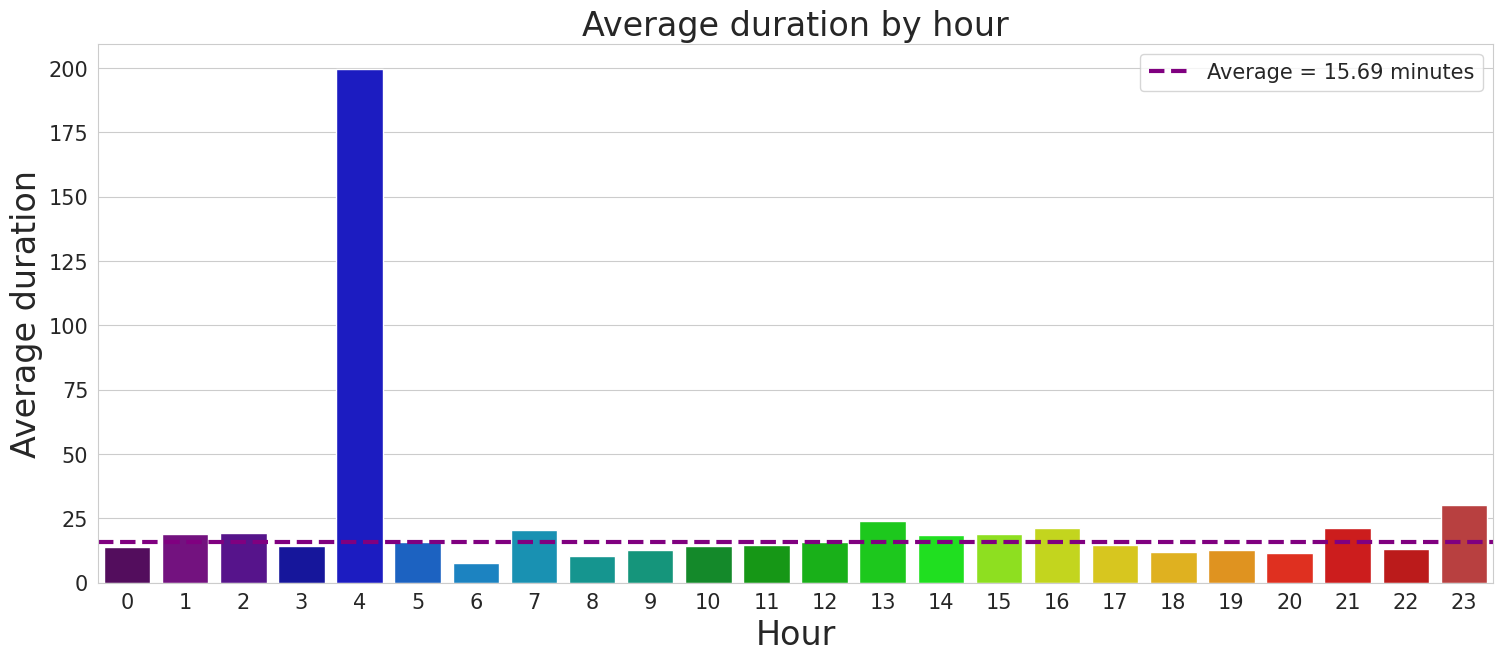

In [40]:
plt.figure(figsize=(18, 7))
plot = sns.barplot(x="Hour", y="Average Trip Duration", data=adbh, palette="nipy_spectral")
plot.axhline(avd, linestyle="--", color="purple", label=f"Average = {avd} minutes", linewidth=3)
plt.title("Average duration by hour", size=24)
plt.xlabel("Hour", size=24)
plt.ylabel("Average duration", size=24)
plt.legend(prop={'size': 15})
plt.xticks(size=15)
plt.yticks(size=15)
plt.show()

### 7. Trips statistics for first and last 15 days

#### First 15 days

In [41]:
ftd = df[(df["Start Date"] >= "2015-09-21") & (df["Start Date"] <= "2015-10-4")]
ftd["Time Period"] = "First 15 Days"

#### Last 15 days

In [42]:
ltd = df[(df["Start Date"] >= "2017-03-18") & (df["Start Date"] <= "2017-03-31")]
ltd["Time Period"] = "Last 15 Days"

In [43]:
fltd = pd.concat([ftd, ltd])

#### 7.1. Statistics by time period

In [44]:
fl_15 = fltd.groupby("Time Period").agg({"Time Period": "count",
                                         "Trip_Duration_in_min": "mean"})
fl_15.columns = ["Trips", "Trips Duration"]
fl_15["Trips Duration"] = round(fl_15["Trips Duration"], 2)
fl_15 = fl_15.reset_index()
fl_15

,Time Period,Trips,Trips Duration
0,First 15 Days,13089,44.27
1,Last 15 Days,22596,10.39


#### 7.2. Statistics by day of week and time period

In [45]:
fltdg = fltd.groupby(["Day Of Week", "Time Period"]).agg({"Time Period": "count",
                                                          "Trip_Duration_in_min": "mean"})
fltdg["Trip_Duration_in_min"] = round(fltdg["Trip_Duration_in_min"],2)
fltdg.columns = ["Trips", "Trips Duration"]
fltdg = fltdg.reset_index()
fltdg

,Day Of Week,Time Period,Trips,Trips Duration
0,Friday,First 15 Days,1405,14.19
1,Friday,Last 15 Days,2940,15.51
2,Monday,First 15 Days,971,17.89
3,Monday,Last 15 Days,3064,9.70
4,Saturday,First 15 Days,2063,184.50
5,Saturday,Last 15 Days,2044,17.22
6,Sunday,First 15 Days,3403,23.02
7,Sunday,Last 15 Days,1640,8.72
8,Thursday,First 15 Days,2765,15.05
9,Thursday,Last 15 Days,4612,8.95


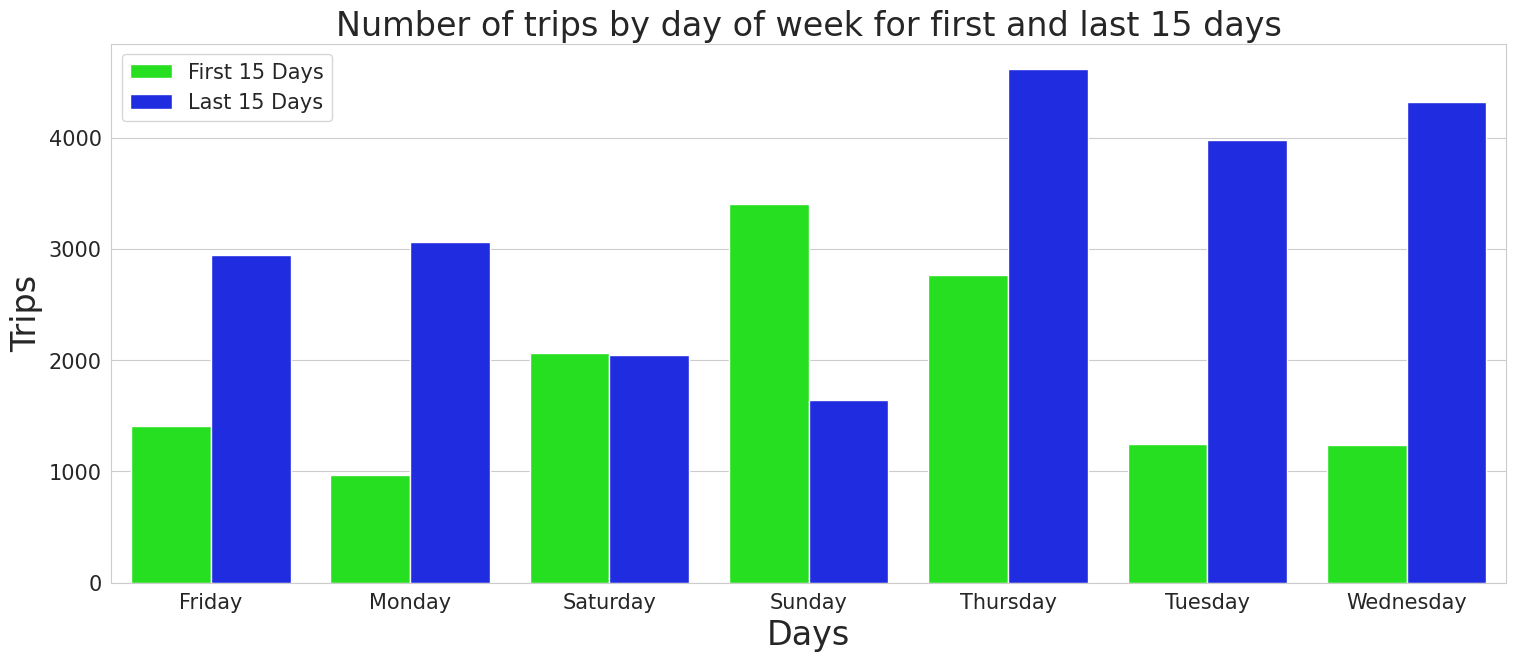

In [46]:
plt.figure(figsize=(18, 7))
sns.barplot(x="Day Of Week", y="Trips", hue="Time Period", data=fltdg, palette="hsv")
plt.title("Number of trips by day of week for first and last 15 days", size=24)
plt.xlabel("Days", size=24)
plt.ylabel("Trips", size=24)
plt.legend(prop={'size': 15})
plt.xticks(size=15)
plt.yticks(size=15)
plt.show()

#### 7.3. Statistics by hour and time period

In [47]:
fltdh = fltd.groupby(["Hour", "Time Period"])["Time Period"].agg(["count"]).reset_index()
fltdh.columns = ["Hour", "Time Period", "Trips"]
fltdh

,Hour,Time Period,Trips
0,0,First 15 Days,176
1,0,Last 15 Days,164
2,1,First 15 Days,53
3,1,Last 15 Days,68
4,2,First 15 Days,49
5,2,Last 15 Days,36
6,3,First 15 Days,7
7,3,Last 15 Days,20
8,4,First 15 Days,27
9,4,Last 15 Days,124


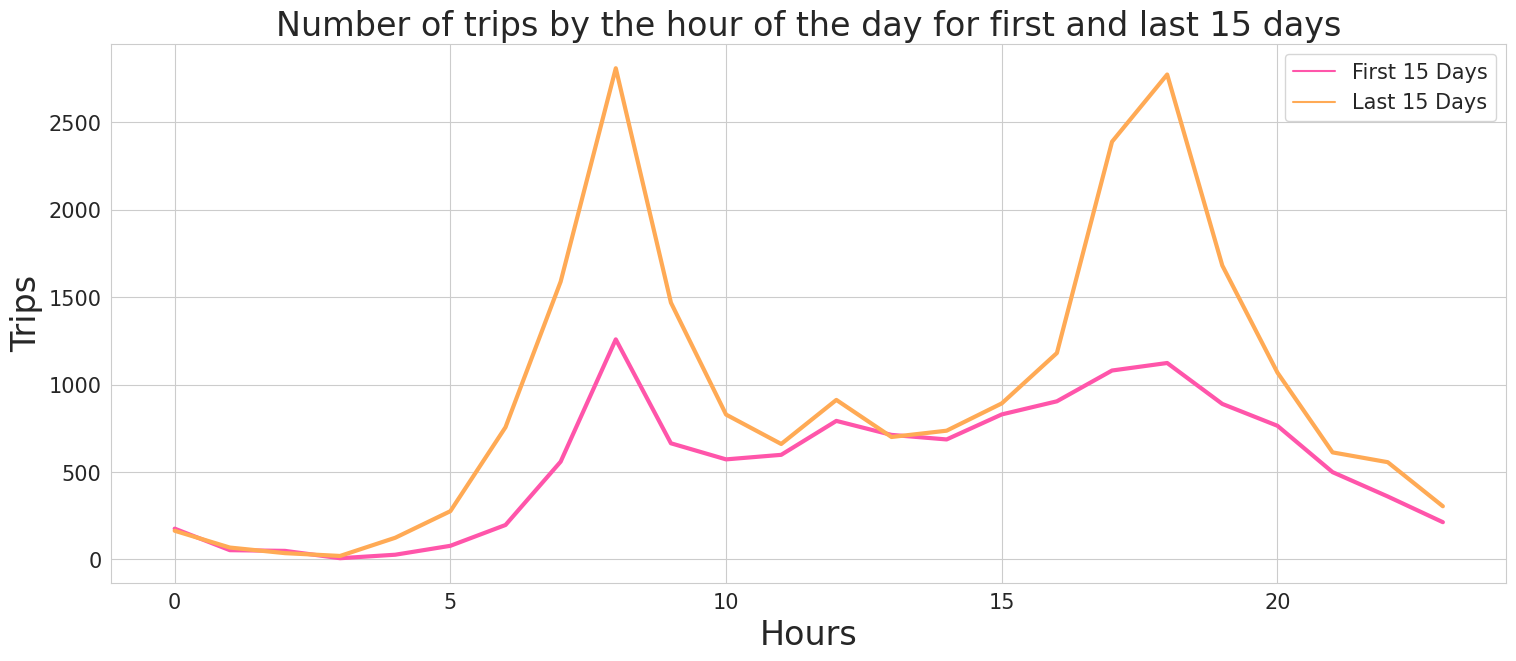

In [48]:
plt.figure(figsize=(18, 7))
sns.lineplot(x="Hour", y="Trips", hue="Time Period", data=fltdh, palette="spring", linewidth=3)
plt.title("Number of trips by the hour of the day for first and last 15 days", size=24)
plt.xlabel("Hours", size=24)
plt.ylabel("Trips", size=24)
plt.legend(prop={'size': 15})
plt.xticks(size=15)
plt.yticks(size=15)
plt.show()

### 8. Starts analysis


#### 8.1. Starts count on map

In [49]:
df_location_start = df[['Start Centroid Latitude', 'Start Centroid Longitude']].dropna()
df_location_start, counts_start = np.unique(df_location_start, return_counts=True, axis=0)
df_location_start = np.append(df_location_start, counts_start.reshape((df_location_start.shape[0], -1)), axis=1)

In [50]:
def draw_starts_number_map(data):
    location_start_map = folium.Map(location=[40.71958611647166, -74.0431174635887], zoom_start=13)
    for row in data:
        lat = row[0]
        long = row[1]
        count = row[2]
        radius = count / 3500
        color = "#FF4500"
        popup_text = """Latitude : {}<br>
                    Longitude : {}<br>
                    Starts numer : {}<br>"""
        popup_text = popup_text.format(lat, long, count)
        folium.CircleMarker(location=(lat, long), fill=True, radius=radius, popup=popup_text, color=color).add_to(
            location_start_map)
    return location_start_map


draw_starts_number_map(df_location_start)

#### 8.1. Put back location

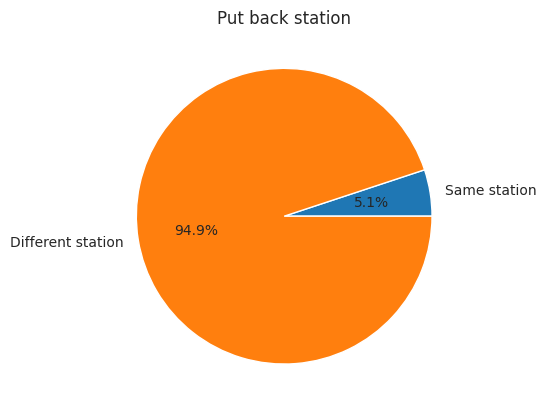

In [51]:
areas = df[["Start Station Name", 'End Station Name']].value_counts().to_frame().reset_index()
areas.columns = ["Start Station Name", 'End Station Name', "count"]
same_district = areas[(areas["Start Station Name"] == areas['End Station Name'])].reset_index()
different_district = areas[(areas["Start Station Name"] != areas['End Station Name'])].reset_index()

fig, ax = plt.subplots()
ax.pie([same_district["count"].sum(), different_district["count"].sum()],
       labels=["Same station", "Different station"], autopct='%1.1f%%')
plt.title("Put back station")
plt.show()

### 9. Traffic flow analysis


In [52]:
areas = df[["Start Area Name", 'End Area Name']].dropna()
unique_areas = np.unique(areas)
area_count = unique_areas.shape[0]
areas_map = {}
for i, area_no in enumerate(unique_areas):
    areas_map[area_no] = i

different_district = areas[
    (areas["Start Area Name"] != areas['End Area Name'])]  #.reset_index()

transfer_arr = np.zeros(shape=(area_count, area_count), dtype=np.int32)

for i, trip in enumerate(different_district.iloc):
    t0 = np.str(trip[0])
    t1 = np.str(trip[1])
    if t0 > t1:
        transfer_arr[areas_map[t0], areas_map[t1]] += 1
    else:
        transfer_arr[areas_map[t0], areas_map[t1]] -= 1

In [53]:
transfer_arr_norm = transfer_arr / np.linalg.norm(transfer_arr)
print(transfer_arr_norm.shape)

(102, 102)


In [54]:
area_geo_start_position = df[['Start Area Name', 'Start Centroid Latitude', 'Start Centroid Longitude']].dropna()
area_geo_start_position = area_geo_start_position.drop_duplicates(subset="Start Area Name")
area_geo_start_position = area_geo_start_position.sort_values(by=['Start Area Name'])
area_geo_start_position = np.array(area_geo_start_position)
area_geo_end_position = df[['End Area Name', 'End Centroid Latitude', 'End Centroid Longitude']].dropna()
area_geo_end_position = area_geo_end_position.drop_duplicates(subset="End Area Name")
area_geo_end_position = area_geo_end_position.sort_values(by=['End Area Name'])
area_geo_end_position = np.array(area_geo_end_position)
area_geo_position = np.concatenate((area_geo_start_position,area_geo_end_position),0)

In [55]:
list_colors = [
    "#00FF00",
    "#12FF00",
    "#24FF00",
    "#35FF00",
    "#47FF00",
    "#58FF00",
    "#6AFF00",
    "#7CFF00",
    "#8DFF00",
    "#9FFF00",
    "#B0FF00",
    "#C2FF00",
    "#D4FF00",
    "#E5FF00",
    "#F7FF00",
    "#FFF600",
    "#FFE400",
    "#FFD300",
    "#FFC100",
    "#FFAF00",
    "#FF9E00",
    "#FF8C00",
    "#FF7B00",
    "#FF6900",
    "#FF5700",
    "#FF4600",
    "#FF3400",
    "#FF2300",
    "#FF1100",
    "#FF0000",
]
color_dict = {i: list_colors[i] for i in range(len(list_colors))}

In [56]:
def draw_flow_map(treshold=1):
    max_count = np.max(transfer_arr)
    print(max_count)
    location_start_map = folium.Map(location=[40.71958611647166, -74.0431174635887], zoom_start=13)
    for y in range(transfer_arr.shape[0]):
        for x in range(transfer_arr.shape[1]):
            if x > y and np.abs(transfer_arr[x, y]) > max_count * treshold:
                start_lat = area_geo_position[x, 1]
                start_long = area_geo_position[x, 2]
                end_lat = area_geo_position[y, 1]
                end_long = area_geo_position[y, 2]

                coordinates = [
                    [start_lat, start_long],
                    [end_lat, end_long]
                ]

                color = np.floor(np.log(np.abs(transfer_arr[x, y])) * (30 / np.ceil(np.log(max_count))))
                line = folium.PolyLine(locations=coordinates, weight=color / 2, color=color_dict[color])
                location_start_map.add_child(line)

                geodesic = Geod(ellps='WGS84')
                if transfer_arr[x, y] > 0:
                    rotation = geodesic.inv(start_long, start_lat, end_long, end_lat)[0] - 90
                    arrow_head = folium.RegularPolygonMarker(location=(
                    (end_lat - start_lat) * 0.95 + start_lat, (end_long - start_long) * 0.95 + start_long),
                                                             color=color_dict[color], number_of_sides=3,
                                                             radius=color * 0.75, rotation=rotation)
                else:
                    rotation = geodesic.inv(end_long, end_lat, start_long, start_lat)[0] - 90
                    arrow_head = folium.RegularPolygonMarker(
                        location=((start_lat - end_lat) * 0.95 + end_lat, (start_long - end_long) * 0.95 + end_long),
                        color=color_dict[color], number_of_sides=3, radius=color * 0.75, rotation=rotation)
                location_start_map.add_child(arrow_head)
    return location_start_map

In [57]:
draw_flow_map(0.01)

20603


#### 9.1. Traffic flow - morning

In [58]:
def parseDateTime(dateTime: str, fromTime: int, toTime: int):
    result = []
    for dT in dateTime:
        tmp = dT.split()[1:3]
        hour = int(tmp[0].split(':')[0])
        if fromTime <= hour <= toTime:
            result.append(True)
        else:
            result.append(False)
    return np.array(result)

In [59]:
areas = df[["Start Time", "Start Area Name", "End Area Name"]].dropna()
district_filter = np.array(areas["Start Area Name"] != areas['End Area Name'])
hour_filter = parseDateTime(areas['Start Time'], 6, 10)
sum_filter = []
for i in range(len(district_filter)):
    if district_filter[i] == True and hour_filter[i] == True:
        sum_filter.append(True)
    else:
        sum_filter.append(False)
hour_district = np.array(areas[sum_filter])
transfer_arr = np.zeros(shape=(area_count, area_count), dtype=np.int32)

for i, trip in enumerate(hour_district):
    t0 = np.str(trip[1])
    t1 = np.str(trip[2])
    if t0 > t1:
        transfer_arr[areas_map[t0], areas_map[t1]] += 1
    else:
        transfer_arr[areas_map[t0], areas_map[t1]] -= 1

In [60]:
draw_flow_map(0.01)

14592


#### 9.2. Traffic flow - afternoon


In [61]:
draw_flow_map(0.01)

14592


#### 9.3 Traffic flow per hour

In [62]:
start_area = df[['Start Station Name', 'Hour']].groupby(
    ["Start Station Name", "Hour"]).value_counts().reset_index()
start_area.columns = ["Area", "Hour", "Trips"]
start_area["Type"] = ["Start"] * len(start_area)
end_area = df[['End Station Name', 'Hour']].groupby(
    ["End Station Name", "Hour"]).value_counts().reset_index()
end_area.columns = ["Area", "Hour", "Trips"]
end_area["Type"] = ["End"] * len(end_area)
area_hour_start_end = pd.concat([start_area, end_area])
area_hour_start_end

,Area,Hour,Trips,Type
0,5 Corners Library,0,173,Start
1,5 Corners Library,1,62,Start
2,5 Corners Library,2,50,Start
3,5 Corners Library,3,29,Start
4,5 Corners Library,4,35,Start
...,...,...,...,...
1264,West St & Chambers St,19,4,End
1265,West Thames St,14,4,End
1266,West Thames St,17,2,End
1267,William St & Pine St,8,2,End


In [63]:
def plot_area_hour_start_end(district):
    plt.figure(figsize=(13, 5))
    sns.barplot(x="Hour", y="Trips", hue="Type", data=area_hour_start_end[area_hour_start_end['Area'] == district],
                palette="hsv")
    plt.title(f'Number of starts and ends by hour in {district}', size=24)
    plt.xlabel("Hours", size=24)
    plt.ylabel("Trips", size=24)
    plt.legend(prop={'size': 15})
    plt.xticks(size=15)
    plt.yticks(size=15)
    plt.show()


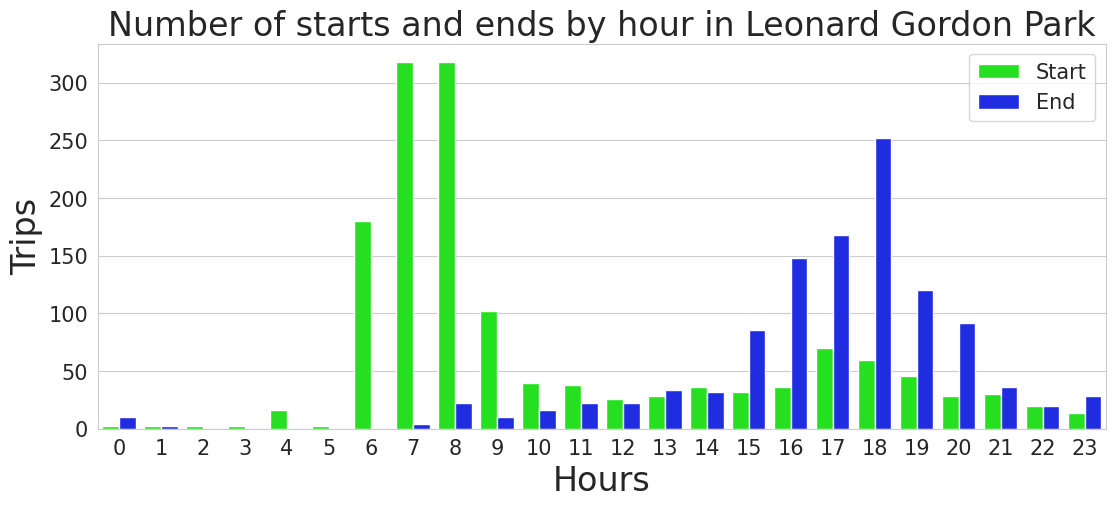

In [64]:
districts = ["Leonard Gordon Park"]
for district in districts:
    plot_area_hour_start_end(district)

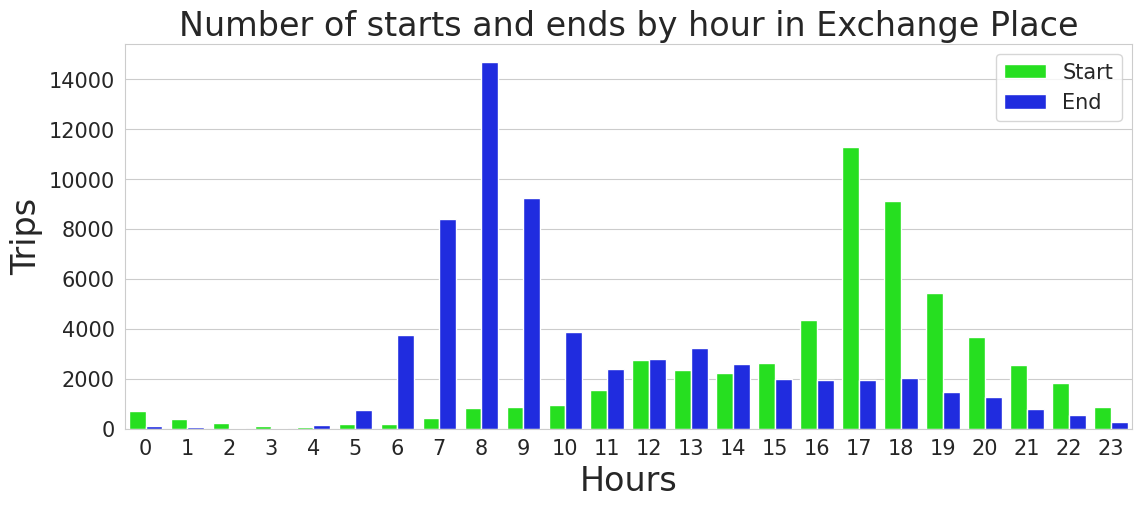

In [65]:
districts = ["Exchange Place"]
for district in districts:
    plot_area_hour_start_end(district)

In [66]:
start_area = df[['Start Area Name', 'Hour']].groupby(["Start Area Name", "Hour"]).value_counts().reset_index()
start_area.columns = ["Area", "Hour", "Trips"]

end_area = df[['End Area Name', 'Hour']].groupby(["End Area Name", "Hour"]).value_counts().reset_index()
end_area.columns = ["Area", "Hour", "Trips"]

morning_start_area = start_area[(start_area["Hour"] >= 5) & (start_area["Hour"] <= 10)].groupby("Area").agg({"Trips": "sum"}).reset_index()
morning_end_area = end_area[(end_area["Hour"] >= 5) & (end_area["Hour"] <= 10)].groupby("Area").agg({"Trips": "sum"}).reset_index()
morning_start_area.columns = ["Area", "Starts"]
morning_end_area.columns = ["Area", "Ends"]
morning = pd.merge(morning_start_area, morning_end_area, on='Area')

evening_start_area = start_area[(start_area["Hour"] >= 15) & (start_area["Hour"] <= 19)].groupby("Area").agg({"Trips": "sum"}).reset_index()
evening_end_area = end_area[(end_area["Hour"] >= 15) & (end_area["Hour"] <= 19)].groupby("Area").agg({"Trips": "sum"}).reset_index()
evening_start_area.columns = ["Area", "Starts"]
evening_end_area.columns = ["Area", "Ends"]
evening = pd.merge(evening_start_area, evening_end_area, on='Area')
evening

,Area,Starts,Ends
0,1st Street,8308,11529
1,Baldwin Avenue,3086,5004
2,Bartholdi Avenue,133,419
3,Beacon Avenue,1492,3074
4,Berry Lane,88,144
5,Brunswick Street,6062,15515
6,Central Avenue,3665,7422
7,Christopher Columbus Drive,50718,21335
8,Congress Street,2284,1977
9,Culver Avenue,707,574


In [67]:
def draw_starts_number_map(data):
    location_start_map = folium.Map(location=[40.71958611647166, -74.0431174635887], zoom_start=13)
    for area,starts,ends in data:
        area_id = areas_map[area]
        lat = area_geo_position[area_id, 1]
        long = area_geo_position[area_id, 2]
        count = abs(starts-ends)
        color = "#FF0000"
        if starts > ends:
            color = "#008000"

        radius = count / 2500
        popup_text = """Latitude : {}<br>
                    Longitude : {}<br>
                    Count : {}<br>"""
        popup_text = popup_text.format(lat, long, count)
        folium.CircleMarker(location=(lat, long), fill=True, radius=radius, popup=popup_text, color=color).add_to(location_start_map)
    return location_start_map

#### 9.4 Traffic flow morning hours


In [68]:
draw_starts_number_map(morning.values)
# Green - more starts, Red - more ends

#### 9.4 Traffic flow evening hours

In [69]:
draw_starts_number_map(evening.values)